<a href="https://colab.research.google.com/github/magda-r/nlp-covid19/blob/master/notebooks/nlp_covid19_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 - Tweets' Sentiment Analysis 

Contents:  
1. ...

In [318]:
import pandas as pd
import itertools
import collections
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import warnings
sns.set_theme()
sns.diverging_palette(220, 20, as_cmap=True)

warnings.filterwarnings("ignore")
pd.set_option('mode.chained_assignment', None)

In [201]:
# # Setting up stopwords list
# stopwords = set(STOPWORDS)
# # excluding keywords used in query (collection words)
# stopwords.update(['covid', 'covid19', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine',      'vaccinated', 'lockdown', 'quarantine'])
# # excluding a couple more irrelevant ones
# stopwords.update(['', 'u', 's', 'm', 've', 't', 'don', 're'])

In [202]:
df = pd.read_pickle('../data/covid19_tweets_cleaned.pkl')
# df = pd.read_csv('../data/covid19_tweets_cleaned.csv', converters={'column_name': eval})

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426426 entries, 0 to 426425
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            426426 non-null  int64 
 1   text          426426 non-null  object
 2   datetime      426426 non-null  object
 3   no_replies    426426 non-null  int64 
 4   no_retweets   426426 non-null  int64 
 5   no_likes      426426 non-null  int64 
 6   user          426391 non-null  object
 7   location      320335 non-null  object
 8   no_followers  426426 non-null  int64 
 9   emojis        426426 non-null  object
 10  text_clean    426426 non-null  object
 11  text_stem     426426 non-null  object
 12  text_lem      426426 non-null  object
dtypes: int64(5), object(8)
memory usage: 42.3+ MB


In [208]:
df.head()

id                                               text  \
0  1234267171276099588  #travelbannow\n#Coronavirus outbreak fears cau...   
1  1234267168843403266  It was said that once the president declared i...   
2  1234267164229734401  Postal worker tests positive for coronavirus -...   
3  1234267161855590400  Coronavirus discovered in Moscow\nMilan Connec...   
4  1234267155941789698  Coronavirus: Pence defends Trump Jr claim Demo...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2020-03-01 23:59:59+00:00           0            0         1   
1  2020-03-01 23:59:59+00:00           0            0         4   
2  2020-03-01 23:59:58+00:00           0            0         0   
3  2020-03-01 23:59:57+00:00           0            2         2   
4  2020-03-01 23:59:56+00:00           0            0         0   

                user                   location  no_followers emojis  \
0     GreenMtnBoy359                14th State            194          
1    John D. Pieratt  Austin - Giddings, Texas.         11985          
2   Brazenly🐕Liberal             Back of Beyond          1605          
3  Elisa E. H.❤에리사벳타                         CA           232          
4  Baby to Boomer LS            Near Seattle WA         18104          

                                          text_clean  \
0  travelbannow coronavirus outbreak fears cause ...   
1  it was said that once the president declared i...   
2  postal worker tests positive for coronavirus  ...   
3  coronavirus discovered in moscow milan connect...   
4  coronavirus pence defends trump jr claim democ...   

                                           text_stem  \
0  [travelbannow, outbreak, fear, caus, delta, ai...   
1                 [said, presid, declar, test, free]   
2  [postal, worker, test, posit, abc, news, via, ...   
3          [discov, moscow, milan, connect, lookner]   
4  [penc, defend, trump, jr, claim, democrat, wan...   

                                            text_lem  
0  [travelbannow, outbreak, fear, cause, delta, a...  
1         [said, president, declared, testing, free]  
2  [postal, worker, test, positive, abc, news, vi...  
3   [discovered, moscow, milan, connection, lookner]  
4  [penny, defends, trump, jr, claim, democrat, w...

In [209]:
# Original text
df['text'][22]

"Melinated skin 😎\nWith only three official cases, Africa's low coronavirus rate puzzles health experts https://t.co/MVhoFhYXAU via @FRANCE24"

In [210]:
# Pre-processed text - stemmed
df['text_stem'][22]

['melin',
 'skin',
 'three',
 'offici',
 'case',
 'africa',
 'low',
 'rate',
 'puzzl',
 'health',
 'expert',
 'via',
 'franc']

In [212]:
# Pre-processed text - lemmatized
df['text_lem'][22]

['melinated',
 'skin',
 'three',
 'official',
 'case',
 'africa',
 'low',
 'rate',
 'puzzle',
 'health',
 'expert',
 'via',
 'france']

In [213]:
# Emojis - if applicable
df['emojis'][22]

'😎'

#### Import lexicons  
A lexicon is a dictionary of words that computes the sentiment of a words by analyzing the "semantic orientation" of that word in a text. These codings are made by people, through crowdsorcing, etc.

- **Afinn**: gives the words a number between -5, 5, where -5 means that the words is very negative and 5 means that the words is very positive  
- **Bing**: gives the words an assignment of positive/negative sentiment  
- **NRC**: assigns the words one of the 8 primary emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and 2 sentiments (positive and negative)

In [214]:
afinn = pd.read_csv('../data/lexicons/Afinn.csv')
bing = pd.read_csv('../data/lexicons/Bing.csv')
nrc = pd.read_csv('../data/lexicons/NRC.csv')

In [215]:
afinn.head()

word  value
0    abandon     -2
1  abandoned     -2
2   abandons     -2
3   abducted     -2
4  abduction     -2

In [216]:
bing.head()

word sentiment
0     2-faces  negative
1    abnormal  negative
2     abolish  negative
3  abominable  negative
4  abominably  negative

In [249]:
# filtering out potsitive/negative sentiments from NRC 
nrc = nrc[(nrc['sentiment'] != 'positive') & (nrc['sentiment'] != 'negative')]
nrc.columns = ['word', 'emotion']
nrc.head()

word  emotion
0     abacus    trust
1    abandon     fear
3    abandon  sadness
4  abandoned    anger
5  abandoned     fear

#### Positive-Negative Wordcloud (redone with lemmatized tweets)

In [233]:
all_words = [item for sublist in df['text_lem'] for item in sublist]
counts = collections.Counter(all_words)
top_counts = pd.DataFrame(counts.most_common(16), columns=['word', 'count'])
top_counts = top_counts[top_counts['word'] != 'u'] # where does it come from??

Text(0.5, 1.0, '15 most frequent words')

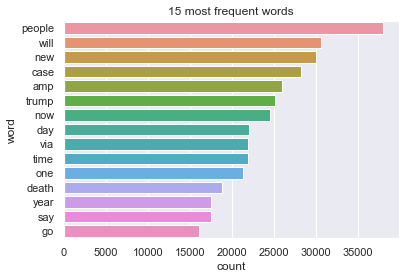

In [336]:
sns.barplot(x=top_counts['count'], y=top_counts['word']).set_title('15 most frequent words')

In [255]:
# join with sentiments from lexicons 
count_df = pd.DataFrame({'word': counts.keys(), 'count': counts.values()})
count_df = count_df.merge(afinn, how='left', on='word')
count_df = count_df.merge(bing, how='left', on='word')
count_df = count_df.merge(nrc, how='left', on='word')
count_df.head(10)

word  count  value sentiment emotion
0  travelbannow      1    NaN       NaN     NaN
1      outbreak   4496    NaN  negative     NaN
2          fear   2826   -2.0  negative   anger
3          fear   2826   -2.0  negative    fear
4         cause   3644    NaN       NaN     NaN
5         delta    145    NaN       NaN     NaN
6       airline    591    NaN       NaN     NaN
7       suspend    210   -1.0       NaN     NaN
8        flight   1127    NaN       NaN     NaN
9         milan     61    NaN       NaN     NaN

In [252]:
pos_words = count_df[cound_df['sentiment'] == 'positive']['word'].drop_duplicates().tolist()
neg_words = count_df[cound_df['sentiment'] == 'negative']['word'].drop_duplicates().tolist()

In [246]:
def filter_sentiment(text, words_to_filter): # veeery slow way
    return [word for word in text if any(n in word for n in words_to_filter)]

# def filter_sentiment(text, words_to_filter):
#     text_s = "".join([word for word in text if word in words_to_filter]) 
#     return text_s

pos_df = df['text_lem'].apply(lambda x: filter_sentiment(x, pos_words))
neg_df = df['text_lem'].apply(lambda x: filter_sentiment(x, neg_words))

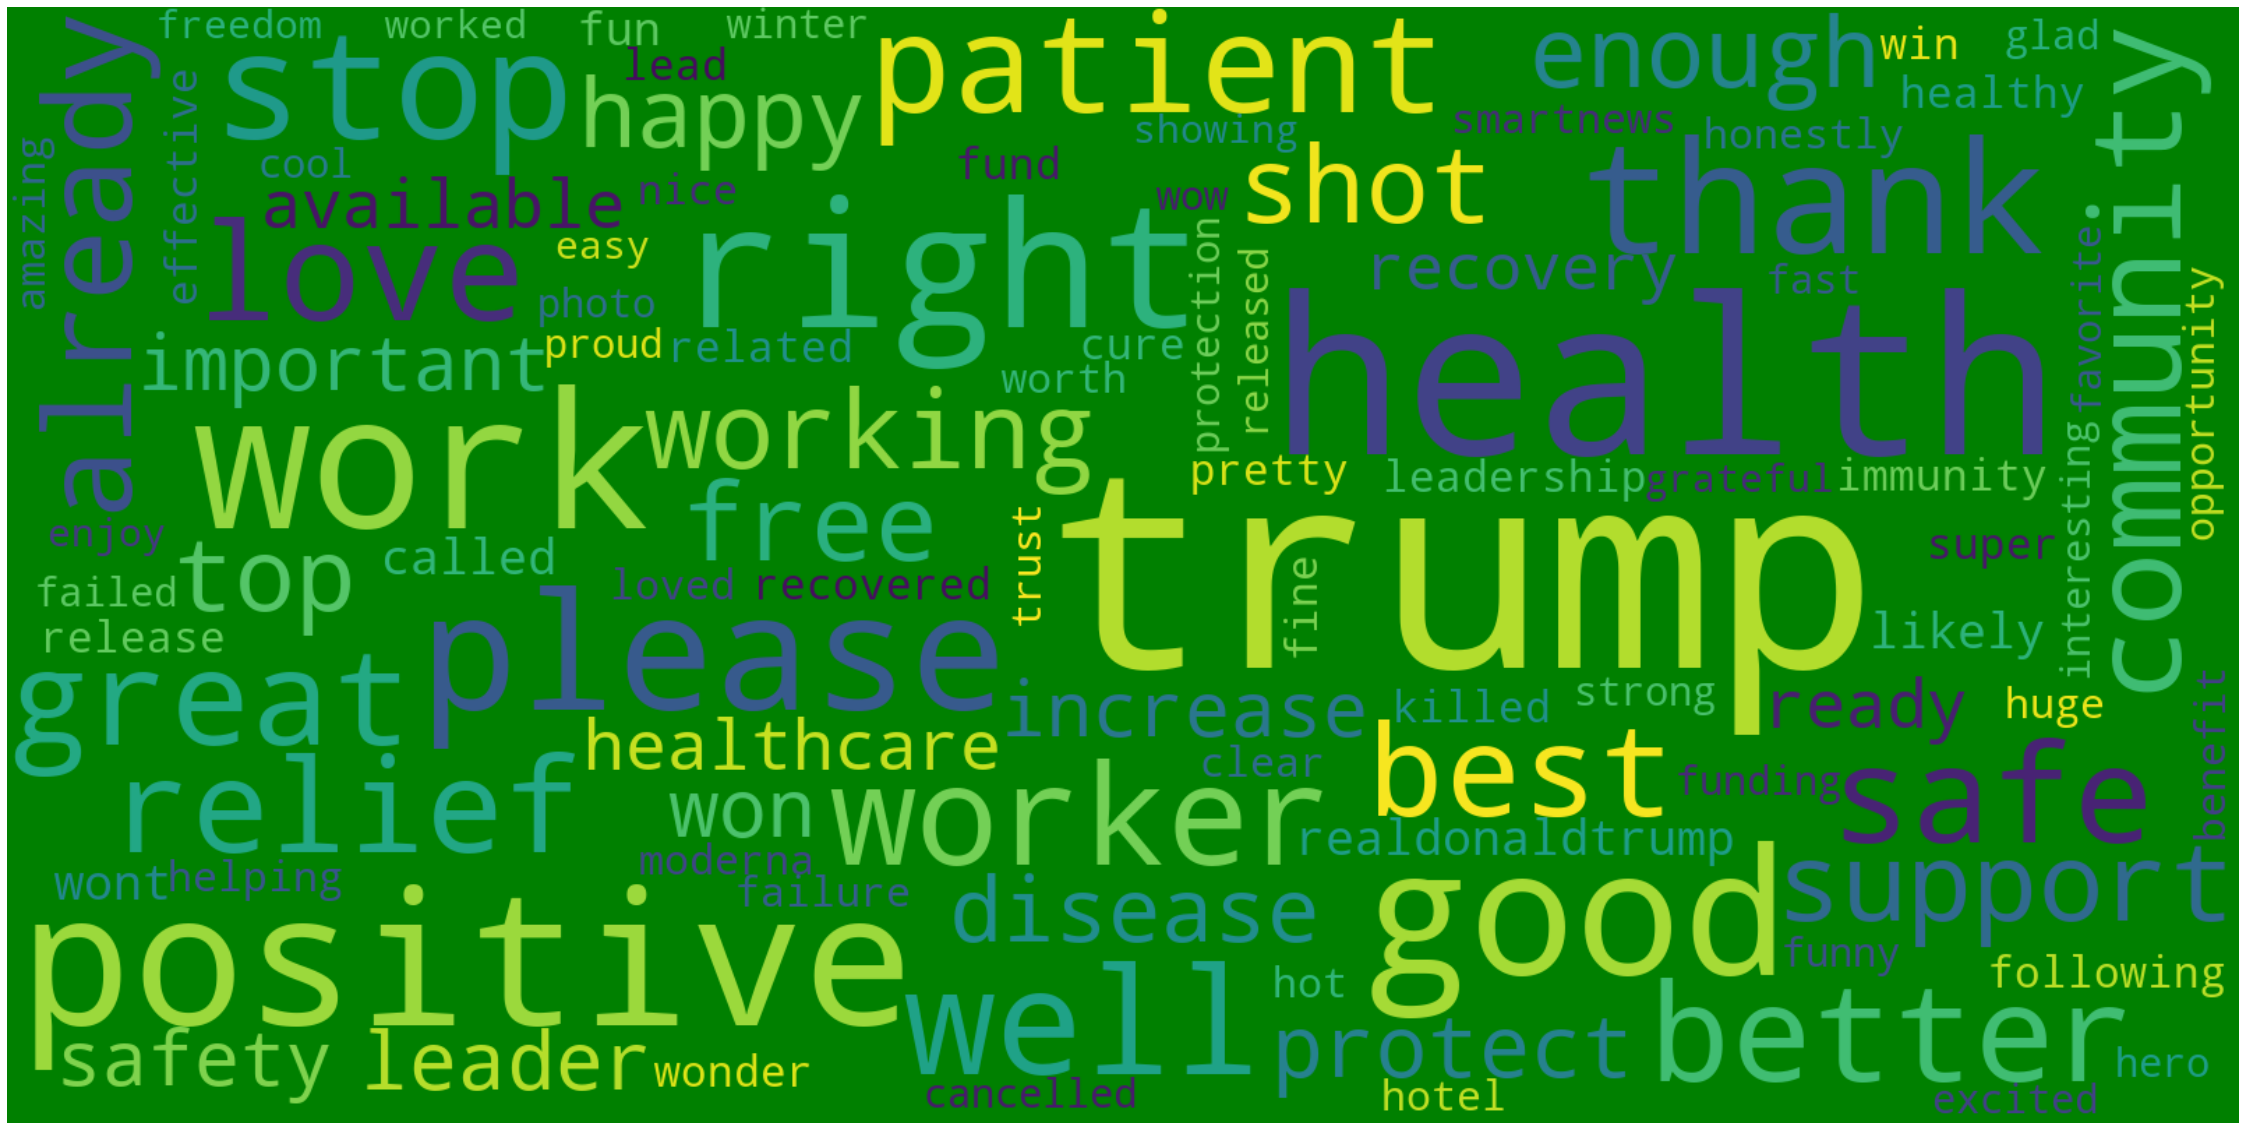

In [247]:
# Positive
string_pos = pos_df.apply(lambda x: " ".join(x))
string_pos = pd.Series(string_pos).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='green').generate_from_text(string_pos)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

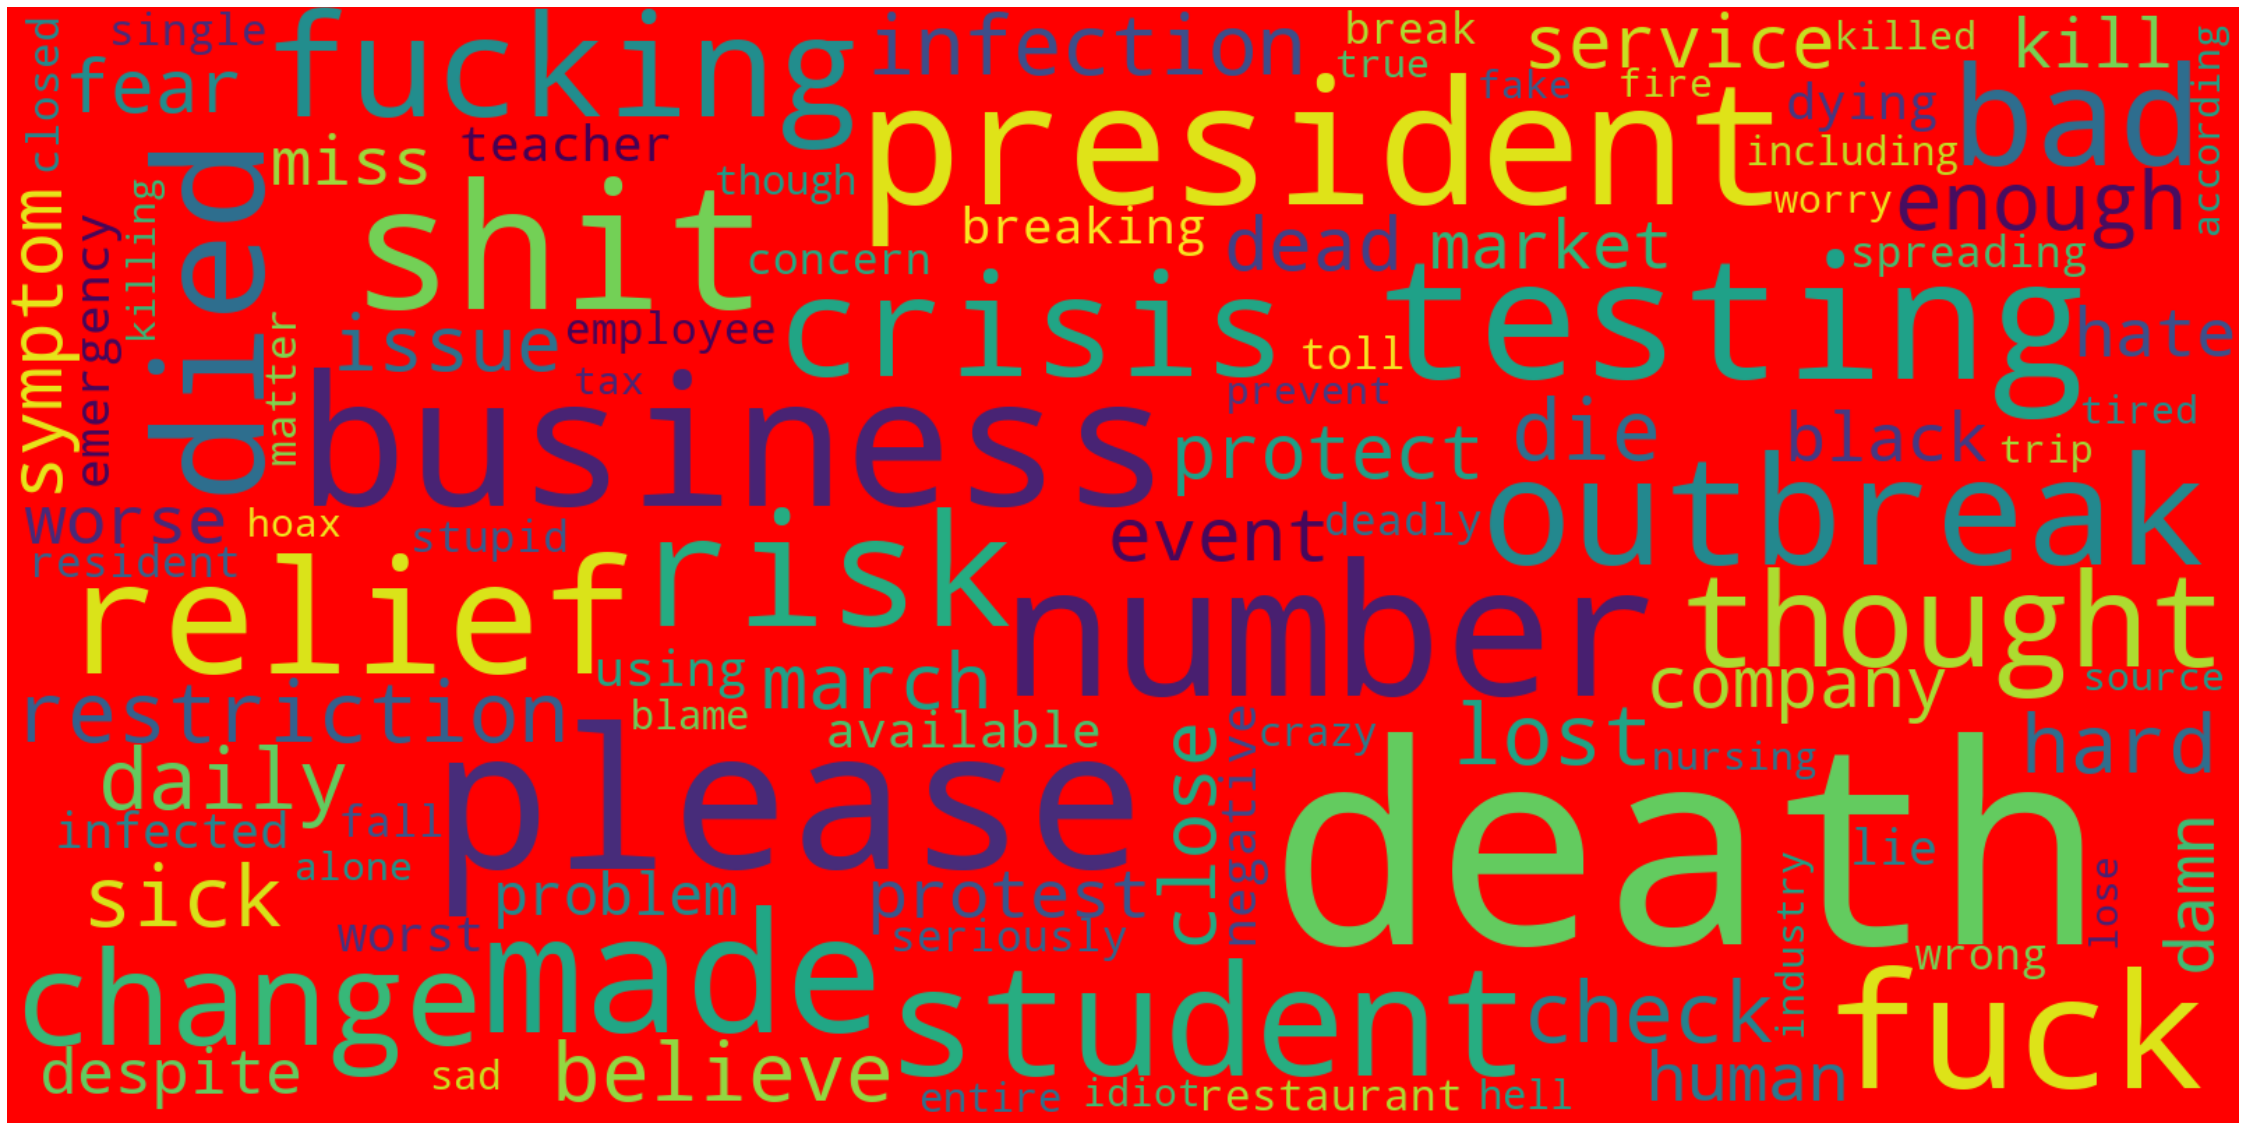

In [248]:
# Negative
string_neg = neg_df.apply(lambda x: " ".join(x))
string_neg = pd.Series(string_neg).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='red').generate_from_text(string_neg)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Primary Emotions Analysis

In [320]:
# emotions taken from NRC lexicon - for multiple matches take first (temporary solution)
sentiment_df = count_df[['count', 'emotion']].dropna()
sentiment_df = sentiment_df.groupby('emotion').first().reset_index()
sentiment_df = sentiment_df.sort_values('count', ascending=False)

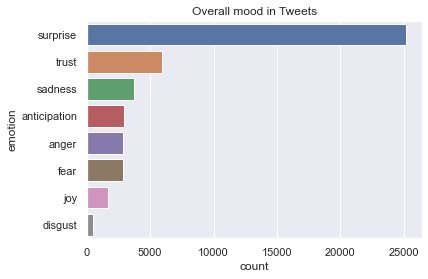

In [325]:
s = sns.barplot(x=emotions_df['count'], y=sentiment_df['emotion']).set_title('Overall mood in Tweets')

#### Emotions Split by Words

In [295]:
emotions_df = count_df[['word', 'count', 'emotion']].dropna()
emotions_df = emotions_df.groupby(['word', 'count']).first().reset_index()
emotions_df = emotions_df.sort_values('count', ascending=False)
emotions_df = emotions_df.groupby('emotion').head(10).reset_index(drop=True)

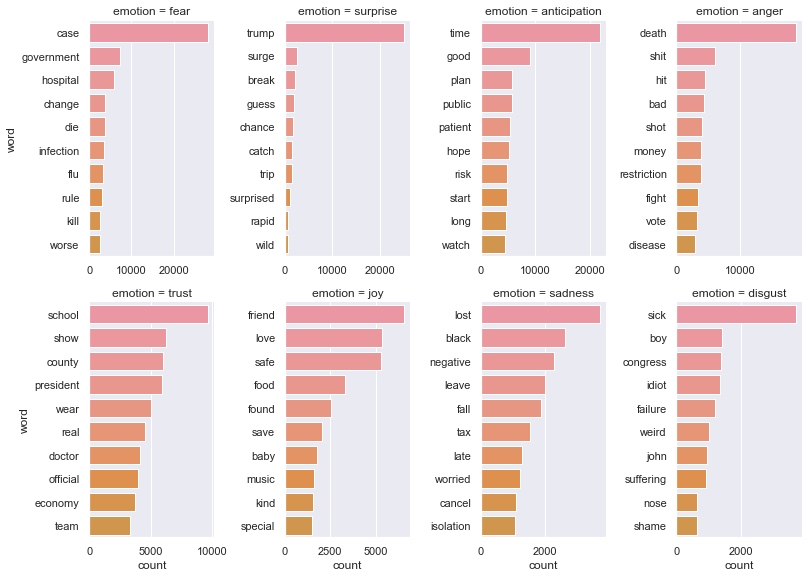

In [311]:
s = sns.catplot(x="count", y="word", col="emotion",
            data=emotions_df, kind="bar",
            height=4, aspect=.7, col_wrap=4, 
            sharex=False, sharey=False, color=None)

#### Sentiment Distribution

In [334]:
value_df = count_df[['word', 'count', 'value']].drop_duplicates().dropna()
value_df = value_df.sort_values('count', ascending=False)#.reset_index(drop=True)
value_df = value_df.groupby('value').sum('count').reset_index()

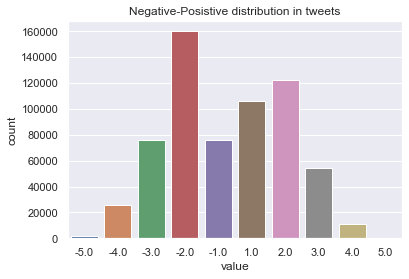

In [335]:
s = sns.barplot(x=value_df['value'], y=value_df['count']).set_title('Negative-Posistive distribution in tweets')

#### Chord Diagram

#### Radar Chart

#### Words with the biggest contribution in sentiment

### VADER

In [21]:
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Magda\AppData\Roaming\nltk_data...


True

In [337]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
 
def classify_compound(text, threshold=0.33):
     
    # initialize VADER
    sid = SentimentIntensityAnalyzer()
     
    # Calling the polarity_scores method on sid and passing in the text
    # outputs a dictionary with negative, neutral, positive, and compound scores for the input text
    scores = sid.polarity_scores(text)
     
    # get compound score
    score = scores['compound']
     
    # translate the score into the correcponding input according to the threshold
    if score <= -threshold: return 'Negative'
    elif score >= threshold: return 'Positive'
    else: return 'Neutral'

### Naive Bayes (with labelled data - to be prepared)